In [6]:
 #!pip install -U accelerate
 #!pip install -U transformers
 #!pip install neptune

In [10]:
import os
import random
import json
import shutil
import copy
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torchvision.models import ResNet34_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import ViTModel, ViTConfig, ViTForImageClassification
from transformers import BertForSequenceClassification, BertTokenizer, BertModel
import neptune as neptune
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1. Data analysis


*   1.1 Here we'll take the Zalando dataset, visualize several examples from different classes and calculate basic statistics (example number, class distribution, etc.).

In [13]:
DEFAULT_RANDOM_SEED = 42

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# basic + torch
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [14]:
seedEverything()

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Load class names from the classes file
with open('data/zalando/meta/classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

# Load train and test splits
with open('data/zalando/meta/train.json') as f:
    train_data = json.load(f)
with open('data/zalando/meta/test.json') as f:
    test_data = json.load(f)

In [15]:
seedEverything()

train_samples = []
test_samples = []
for cls in classes:
    train_samples.extend([(f'data/zalando/images/{x}', x[0:x.find('/')]) for x in train_data[cls]])
    test_samples.extend([(f'data/zalando/images/{x}', x[0:x.find('/')]) for x in test_data[cls]])
print(f'Train size: {len(train_samples)}')
print(f'Test size: {len(test_samples)}')
print(train_samples[0:5])

Train size: 4500
Test size: 1500
[('data/zalando/images/coats/1d260114f0df489b9de8c5cd81d6f26c.jpg', 'coats'), ('data/zalando/images/coats/aeac5c3344364baebbf81d55c2409154.jpg', 'coats'), ('data/zalando/images/coats/3f01a6770cfb49169f7f07d5ed4b8841.jpg', 'coats'), ('data/zalando/images/coats/bd4c26422de640e1a77ffc794593659a.jpg', 'coats'), ('data/zalando/images/coats/207659f6851e469f8a86f77deabf9169.jpg', 'coats')]


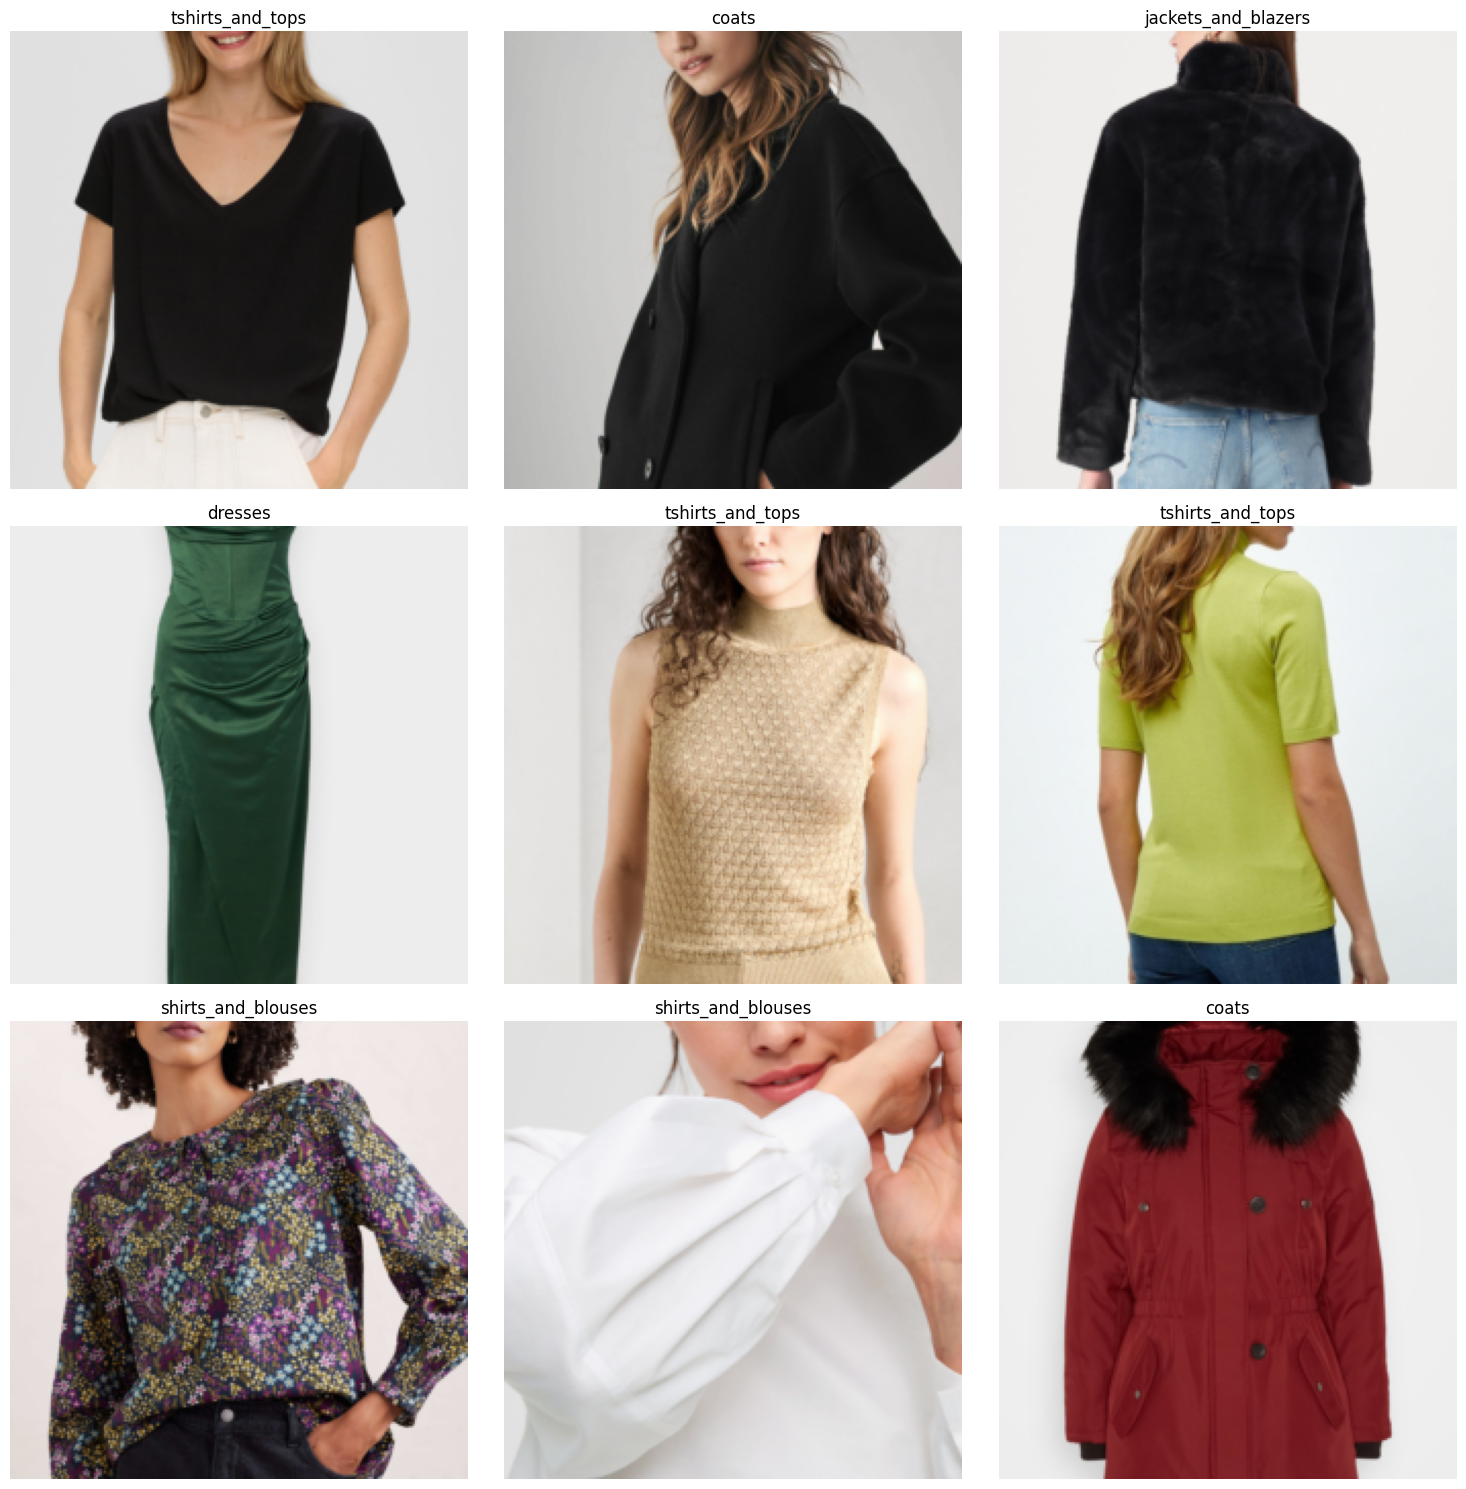

In [16]:
seedEverything()

def load_image(image_path, label):
    img = datasets.folder.default_loader(image_path)
    img = transform(img)
    return img, label

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    cls = random.choice(classes)
    image_name = random.choice(train_data[cls] + test_data[cls])
    image_path = f'data/zalando/images/{image_name}'
    img, label = load_image(image_path, cls)
    ax.imshow(transforms.ToPILImage()(img))
    ax.set_title(cls)
    ax.axis('off')

plt.tight_layout()
plt.show()

* Now let's calculate basic statistics for our selected classes and visualize it:

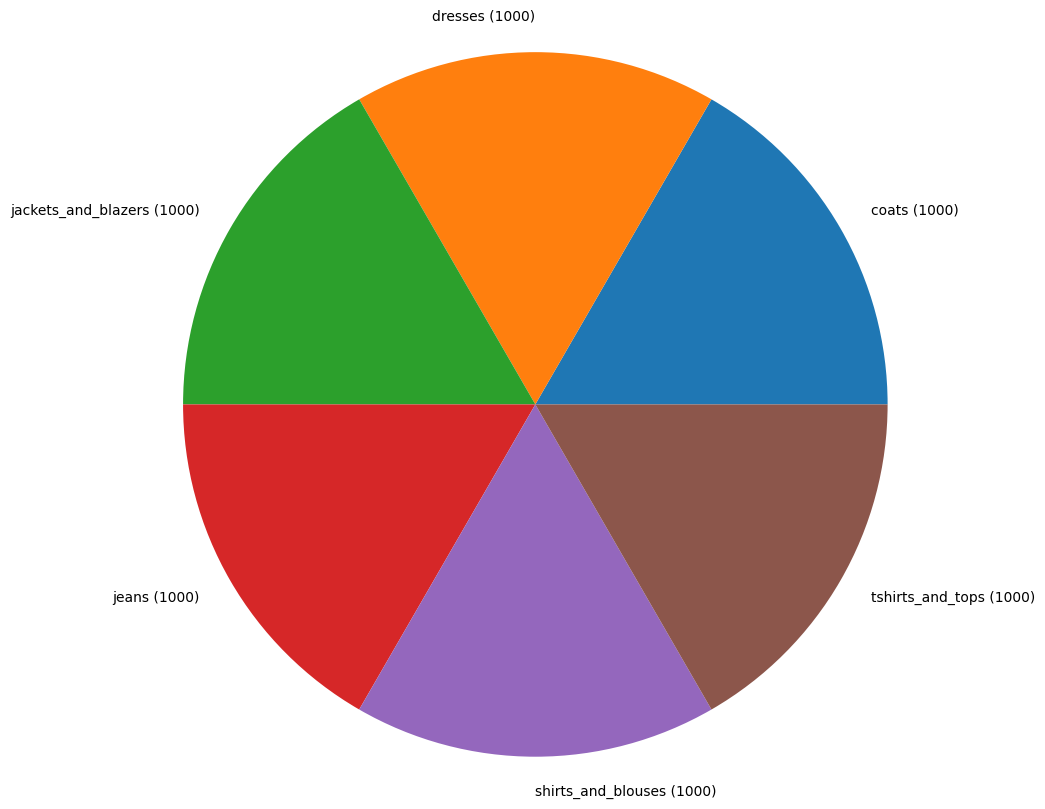

In [17]:
seedEverything()
labels = []
sizes = []

for class_name in classes:
    images = os.listdir(f'data/zalando/images/{class_name}')
    n = len(images)
    labels.append(f'{class_name} ({n})')
    sizes.append(n)

plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels)
plt.axis('equal')
plt.show()

*   1.2 Let's split the data from train into current_train and current_val (val_size = 10%) and fix random_state for reproducibility.

In [18]:
seedEverything()

# Create a custom dataset
class CustomZalandoDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = copy.deepcopy(samples)
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        label_index = classes.index(label)
        image = datasets.folder.default_loader(image_path)  # Load image
        if self.transform:
            image = self.transform(image)  # Apply transformations
        return image, label_index

# Initialize the custom dataset
train_dataset = CustomZalandoDataset(train_samples, transform=transform)
test_dataset = CustomZalandoDataset(test_samples, transform=transform)

# Splitting the dataset into current_train and current_val
total_train_count = len(train_dataset)
val_count = int(total_train_count * 0.1)  # 10% for validation
train_count = total_train_count - val_count  # Remaining for training
current_train, current_val = torch.utils.data.random_split(train_dataset, [train_count, val_count], generator=torch.Generator().manual_seed(42))

# Data loaders for both subsets
train_loader = torch.utils.data.DataLoader(current_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(current_val, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f'Size of the train dataset before the split: {total_train_count}')
print(f'Size of the val dataset: {val_count}')
print(f'Size of the train dataset after the split: {train_count}')
print(f'Size of the test dataset: {len(test_dataset)}')

Size of the train dataset before the split: 4500
Size of the val dataset: 450
Size of the train dataset after the split: 4050
Size of the test dataset: 1500


### 2. ResNet Fine-tuning
* 2.1   Let's take pre-trained [ResNet](https://pytorch.org/vision/main/models/resnet.html) from torchvision.

In [19]:
seedEverything()

# Training ResNet34
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load pre-trained ResNet34 model
weights = ResNet34_Weights.IMAGENET1K_V1
resnet34 = models.resnet34(weights=weights)

# Modify the classifier to fit the number of classes (6)
num_ftrs = resnet34.fc.in_features
resnet34.fc = nn.Linear(num_ftrs, 6)
resnet34 = resnet34.to(device)

cpu


In [20]:
seedEverything()

# Model training function
def train_model(model, model_name, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    # Initialize Neptune run
    run = neptune.init_run(
        project="kofmanya/Clothing-Category-Recognition",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4MmUyOTZjYy1mNzFjLTQ4YzUtYjk4Yi1hZmIxMTk5OWYwMDgifQ==",
    )
    run["parameters"] = {
        "model": model_name,
        "batch_size": 16,
        "learning_rate": 0.001,
        "epochs": num_epochs
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits if model_name == "ViT" else outputs, 1)
            loss = criterion(outputs.logits if model_name == "ViT" else outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            train_progress.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Log training metrics
        run[f"train/{model_name}_loss"].log(epoch_loss)
        run[f"train/{model_name}_accuracy"].log(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")

        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs.logits if model_name == "ViT" else outputs, 1)
                loss = criterion(outputs.logits if model_name == "ViT" else outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

                val_progress.set_postfix(loss=loss.item())

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        # Log validation metrics
        run[f"val/{model_name}_loss"].log(val_loss)
        run[f"val/{model_name}_accuracy"].log(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save and log model
    model_path = f"{model_name}.pth"
    torch.save(model.state_dict(), model_path)
    run[f"model/{model_name}_weights"].upload(model_path)

    run.stop()
    return model

* 2.2   Now we'll fine-tune pre-trained ResNet on `current_train` created in 1.2 and validate it on `current_val` created in 1.2 in process of training. Let's also track our experiments using Neptune.

In [21]:
seedEverything()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet34.parameters(), lr=0.001, momentum=0.9)

trained_resnet34 = train_model(resnet34, "ResNet34", criterion, optimizer, train_loader, val_loader, num_epochs=5)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kofmanya/Clothing-Category-Recognition/e/CLOT-25


Epoch 1/5 [Validation]: 100%|███████████████████████████████████| 29/29 [00:32<00:00,  1.13s/it, loss=0.552]


Epoch 1/5, Train Loss: 1.0946, Train Acc: 0.5785, Val Loss: 0.8713, Val Acc: 0.6622


Epoch 2/5 [Validation]: 100%|███████████████████████████████████| 29/29 [00:33<00:00,  1.16s/it, loss=0.293]


Epoch 2/5, Train Loss: 0.6322, Train Acc: 0.7677, Val Loss: 0.8426, Val Acc: 0.7067


Epoch 3/5 [Validation]: 100%|███████████████████████████████████| 29/29 [00:34<00:00,  1.19s/it, loss=0.358]


Epoch 3/5, Train Loss: 0.3660, Train Acc: 0.8763, Val Loss: 0.8787, Val Acc: 0.6978


Epoch 4/5 [Validation]: 100%|████████████████████████████████████| 29/29 [00:34<00:00,  1.18s/it, loss=0.81]


Epoch 4/5, Train Loss: 0.2316, Train Acc: 0.9210, Val Loss: 0.8401, Val Acc: 0.7356


Epoch 5/5 [Validation]: 100%|████████████████████████████████████| 29/29 [00:34<00:00,  1.18s/it, loss=1.07]


Epoch 5/5, Train Loss: 0.1552, Train Acc: 0.9454, Val Loss: 0.8390, Val Acc: 0.7244
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kofmanya/Clothing-Category-Recognition/e/CLOT-25/metadata


* 2.3   Now let's evaluate our fine-tuned model (we'll use accuracy metric and data from test part for the evaluation).

In [22]:
seedEverything()

# Shared evaluation function for models
def evaluate_model(model, model_name, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits if model_name == "ViT" else outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Log evaluation metrics to Neptune
    run = neptune.init_run(
        project="kofmanya/Clothing-Category-Recognition",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4MmUyOTZjYy1mNzFjLTQ4YzUtYjk4Yi1hZmIxMTk5OWYwMDgifQ==",
    )
    run[f"test/{model_name}_accuracy"] = accuracy

    print(f"{model_name} Test Accuracy: {accuracy * 100:.2f}%")

    # Save and log confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
    cm_display.plot()
    confusion_matrix_path = f"{model_name}_confusion_matrix.png"
    plt.savefig(confusion_matrix_path)
    run[f"test/{model_name}_confusion_matrix"].upload(confusion_matrix_path)

    run.stop()
    return accuracy * 100

Evaluating ResNet34...
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kofmanya/Clothing-Category-Recognition/e/CLOT-26
ResNet34 Test Accuracy: 75.40%
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kofmanya/Clothing-Category-Recognition/e/CLOT-26/metadata


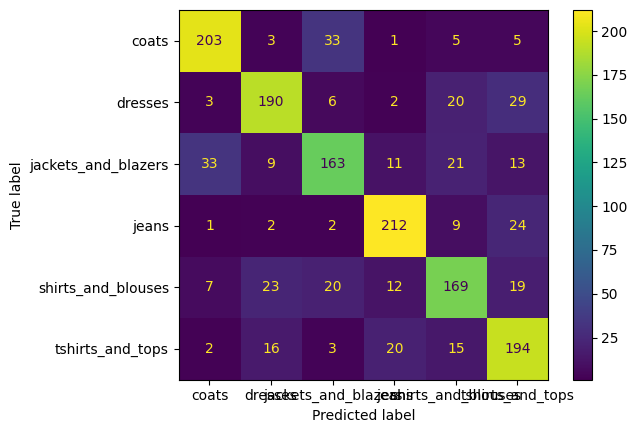

In [23]:
print("Evaluating ResNet34...")
resnet34_accuracy = evaluate_model(trained_resnet34, "ResNet34", test_loader)

### 3. Vit Fine-tuning
In this part we're going to fine-tune [ViT](https://huggingface.co/docs/transformers/model_doc/vit) model from HuggingFace library.

In [24]:
seedEverything()

transform_vit = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),          # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained ViT
])

# Initialize the custom dataset
train_dataset = CustomZalandoDataset(train_samples, transform=transform_vit)
test_dataset = CustomZalandoDataset(test_samples, transform=transform_vit)

# Splitting the dataset into current_train and current_val
total_train_count = len(train_dataset)
val_count = int(total_train_count * 0.1)
train_count = total_train_count - val_count
current_train, current_val = torch.utils.data.random_split(train_dataset, [train_count, val_count], generator=torch.Generator().manual_seed(42))

# Data loaders for both subsets
train_loader = torch.utils.data.DataLoader(current_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(current_val, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f'Size of the train dataset before the split: {total_train_count}')
print(f'Size of the val dataset: {val_count}')
print(f'Size of the train dataset after the split: {train_count}')
print(f'Size of the test dataset: {len(test_dataset)}')

Size of the train dataset before the split: 4500
Size of the val dataset: 450
Size of the train dataset after the split: 4050
Size of the test dataset: 1500


* 3.1 Let's take [Vit](https://huggingface.co/docs/transformers/model_doc/vit) model from HuggingFace library and initialize it with the [weights pre-trained on ImageNet](https://huggingface.co/google/vit-base-patch16-224). Similarly to point 2, let's fine-tune this model on on `current_train` created in 1.2 and validate it on `current_val` created in 1.2 in process of training. Let's also track our experiments using Neptune.

In [25]:
seedEverything()

# Training ViT
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=6)
vit_model = vit_model.to(device)

optimizer_vit = optim.SGD(vit_model.parameters(), lr=0.001, momentum=0.9)
trained_vit_model = train_model(vit_model, "ViT", criterion, optimizer_vit, train_loader, val_loader, num_epochs=5)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kofmanya/Clothing-Category-Recognition/e/CLOT-27


Epoch 1/5 [Validation]: 100%|████████████████████████████████████| 29/29 [00:41<00:00,  1.42s/it, loss=1.59]


Epoch 1/5, Train Loss: 1.3020, Train Acc: 0.6242, Val Loss: 0.9304, Val Acc: 0.7289


Epoch 2/5 [Validation]: 100%|████████████████████████████████████| 29/29 [00:41<00:00,  1.44s/it, loss=2.27]


Epoch 2/5, Train Loss: 0.6847, Train Acc: 0.7919, Val Loss: 0.6727, Val Acc: 0.7778


Epoch 3/5 [Validation]: 100%|████████████████████████████████████| 29/29 [00:41<00:00,  1.43s/it, loss=2.07]


Epoch 3/5, Train Loss: 0.4782, Train Acc: 0.8425, Val Loss: 0.6023, Val Acc: 0.7667


Epoch 4/5 [Validation]: 100%|███████████████████████████████████| 29/29 [00:41<00:00,  1.43s/it, loss=0.858]


Epoch 4/5, Train Loss: 0.3393, Train Acc: 0.8963, Val Loss: 0.5763, Val Acc: 0.7978


Epoch 5/5 [Validation]: 100%|███████████████████████████████████| 29/29 [00:41<00:00,  1.43s/it, loss=0.918]


Epoch 5/5, Train Loss: 0.2726, Train Acc: 0.9168, Val Loss: 0.5520, Val Acc: 0.8067
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] Still waiting for the remaining 3 operations (0.00% done). Please wait.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kofmanya/Clothing-Category-Recognition/e/CLOT-27/metadata


* 3.2 Now, let's evaluate our fine-tuned model (we'll use accuracy metric and data from test part for the evaluation).

Evaluating ViT...
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kofmanya/Clothing-Category-Recognition/e/CLOT-28
ViT Test Accuracy: 81.60%
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kofmanya/Clothing-Category-Recognition/e/CLOT-28/metadata


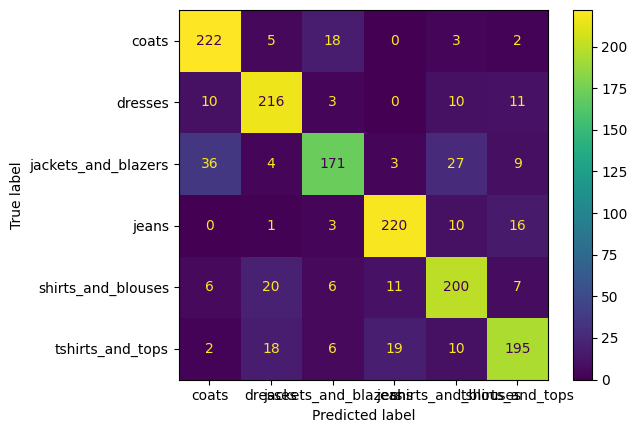

In [26]:
print("Evaluating ViT...")
vit_accuracy = evaluate_model(trained_vit_model, "ViT", test_loader)

### 4. Summary & results analysis


* 4.1 Let's Compare the results of the tested models:





Finally, we have following results:

| Model                                    |  Test score           |
|:-----------------------------------------|:----------------------|
| RezNet34                                 | 75.40                 |
| ViT                                      | 81.60                 |

As we can see, Vit performs better than RezNet34.

### 5. Choosing the best model and uploading it to PROD with Neptune 


* 5.1 Let's use Neptune to analize the results of the tested models and upload a model with the best accurecy score to the PROD:

In [27]:
# Compare models and push the best to production
def compare_and_push_to_prod(resnet_model, vit_model, resnet_accuracy, vit_accuracy):
    # Start a Neptune run to log the comparison
    run = neptune.init_run(
        project="kofmanya/Clothing-Category-Recognition",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4MmUyOTZjYy1mNzFjLTQ4YzUtYjk4Yi1hZmIxMTk5OWYwMDgifQ==",
    )

    # Log accuracies
    run["comparison/ResNet34_accuracy"] = resnet_accuracy
    run["comparison/ViT_accuracy"] = vit_accuracy

    # Determine the best model
    if resnet_accuracy > vit_accuracy:
        best_model_name = "ResNet34"
        best_model_weights = "resnet34.pth"
        torch.save(resnet_model.state_dict(), best_model_weights)
    else:
        best_model_name = "ViT"
        best_model_weights = "vit.pth"
        torch.save(vit_model.state_dict(), best_model_weights)

    # Log the selected model
    run["comparison/best_model"] = best_model_name
    print(f"The best model is: {best_model_name} with accuracy: {max(resnet_accuracy, vit_accuracy):.2f}%")

    # Save the best model to the prod_model directory
    metadata = {"model_name": best_model_name}
    prod_dir = "service/prod_model"
    shutil.rmtree(prod_dir, ignore_errors=True)  # Clear existing directory
    os.makedirs(prod_dir, exist_ok=True)
    shutil.copy(best_model_weights, os.path.join(prod_dir, "model.pth"))

    shutil.copy(best_model_weights, os.path.join(prod_dir, "model.pth"))
    with open(os.path.join(prod_dir, "metadata.json"), "w") as f:
        json.dump(metadata, f)

    # Upload the production model to Neptune
    run["production_model/weights"].upload(os.path.join(prod_dir, "model.pth"))
    run["production_model/name"] = best_model_name

    run.stop()

In [28]:
# Compare and push the best model to production
compare_and_push_to_prod(trained_resnet34, trained_vit_model, resnet34_accuracy, vit_accuracy)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kofmanya/Clothing-Category-Recognition/e/CLOT-29
The best model is: ViT with accuracy: 81.60%
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] Still waiting for the remaining 5 operations (0.00% done). Please wait.
[neptune] [info   ] All 5 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kofmanya/Clothing-Category-Recognition/e/CLOT-29/metadata
